In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

You are given a dataset ("data.h5") containing: - a training set of m_train images labelled as cat (1) or non-cat (0) - a test set of m_test images labelled as cat and non-cat - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1. It's a cat picture.


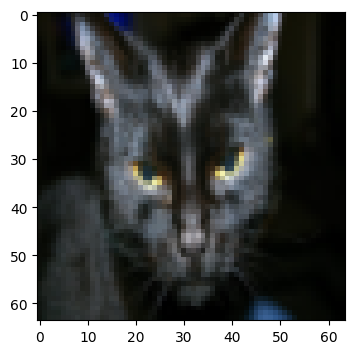

In [3]:
# Example of a picture
index = 25
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB)

In [4]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


reshape and standardize the images before feeding them to the network

In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


12288 = 64 * 64 * 3 which is size of one reshaped image vector.

2 Layer NN

1. I/P is 64,64,3 image flattened to 12288,1
2. correesponding x^T  multiplied by w of shape (n1, 12288)
3. You then add a bias term and take its relu to get the following vector
4. You then repeat the same process.
5. You multiply the resulting vector by and add your intercept (bias).
6. Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

In [6]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [7]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203885
Cost after iteration 900: 0.35807050113237965
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.30527536361962665
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.24681768210614846
Cost after iteration 1400: 0.19850735037466108
Cost after iteration 1500: 0.1744831811255664
Cost after iteration 1600: 0.17080762978096603
Cost after iteration 1700: 0.1130652456216472
Cost after iteration 1800: 0.09629426845937152
Cost after iteration 1900: 0.08342617959726865
Cost after iteration 2000: 0.07439078704319083
Cost after iteration 2100: 0.066307481

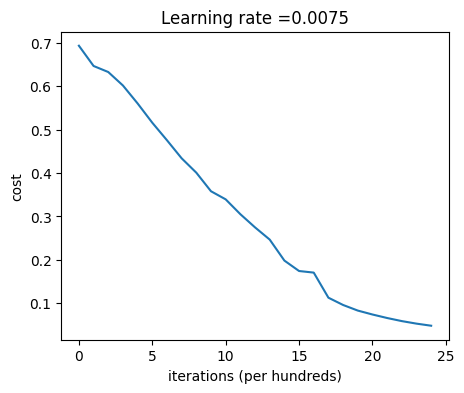

In [10]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [11]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [12]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72
